In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture
from IPython.display import clear_output
import time
import seaborn as sns

# Unconditional Difussion Model

## Sample data generation

In [2]:
def sample_data():
    n_samples = 500
    seed = 30

    all_points, labels = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed)

    all_points = torch.from_numpy(all_points).float()

    mean = torch.mean(all_points, dim=0)
    std = torch.std(all_points, dim=0)
    normalized_points = (all_points - mean) / std

    return normalized_points

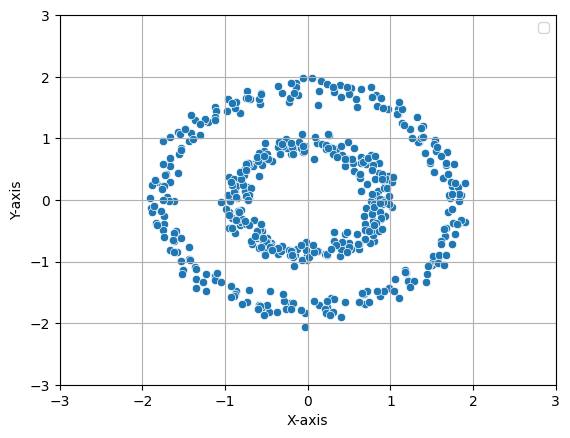

In [3]:
x0 = sample_data()

sns.scatterplot(x=x0[:, 0], y=x0[:, 1])
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.legend()
plt.grid(True)
clear_output(wait=True)
plt.show()

## Scheduler

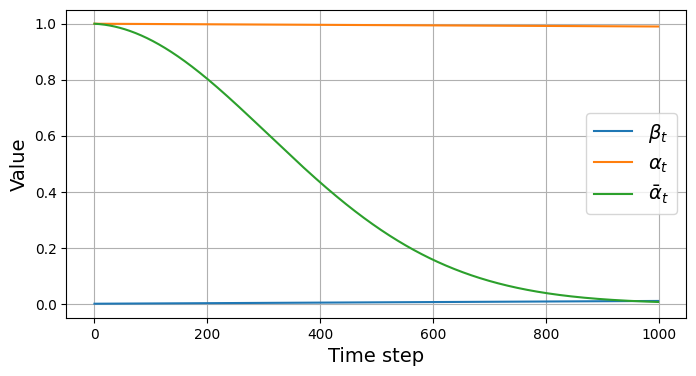

In [6]:
T = 1000

betas = torch.linspace(1e-4, 0.01, T)
alphas = 1-betas
alpha_bars = torch.cumprod(alphas, dim=0)

# make this plot better labelled with latex text
plt.figure(figsize=(8, 4))
plt.plot(betas, label=r"$\beta_t$")
plt.plot(alphas, label=r"$\alpha_t$")
plt.plot(alpha_bars, label=r"$\bar{\alpha}_t$")
plt.xlabel("Time step", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.legend(fontsize=14)
plt.grid(True)
plt.show()

## Forward Difussion

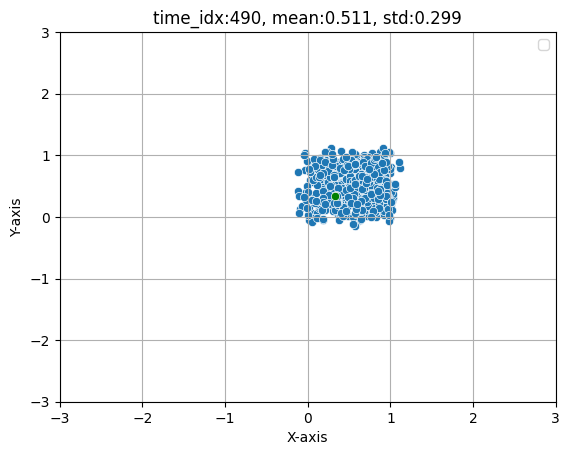

In [9]:
import seaborn as sns

x0 = sample_data()

true_noises = []

for idx, alpha_bar in enumerate(alpha_bars[::20]):

    noise = torch.rand_like(x0)
    true_noises.append(noise)
    x_t1 = torch.sqrt(alpha_bar)*x0 + torch.sqrt(1-alpha_bar) * noise
    # The sqrt is used to make the resulted distribution gaussian with std=1

    sns.scatterplot(x=x_t1[:, 0], y=x_t1[:, 1])
    sns.scatterplot(x=[x_t1[0, 0].item()], y=[x_t1[0, 1].item()], color="green")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.title(f"time_idx:{idx*10}, mean:{torch.mean(x_t1):.3f}, std:{torch.std(x_t1):.3f}")
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.legend()
    plt.grid(True)
    clear_output(wait=True)
    plt.show()

## Train model for Denoising Diffusion Model

In [14]:
# Define the model

class Model(nn.Module):

    def __init__(self, input_dim=2, hidden_dim=128) -> None:

        super().__init__()

        self.layer_norm1 = torch.nn.LayerNorm(input_dim)
        self.layer_norm2 = torch.nn.LayerNorm(hidden_dim)
        self.layer_norm3 = torch.nn.LayerNorm(hidden_dim)
        self.output_norm = torch.nn.LayerNorm(hidden_dim)

        self.activation_fn = torch.nn.LeakyReLU(negative_slope=0.02, inplace=True)

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.skip_fc = nn.Linear(input_dim, hidden_dim)

        self.output_fc = torch.nn.Linear(hidden_dim, input_dim)

        self.time_embedding_layer = nn.Sequential(
            nn.Linear(1, hidden_dim),
            self.activation_fn
        )

    def forward(self, x0, t):
        time_embed = self.time_embedding_layer(t.float())

        xx = self.activation_fn(self.fc1(self.layer_norm1(x0)))
        xx = xx + time_embed + time_embed + self.skip_fc(x0)
        xx = self.activation_fn(self.fc2(self.layer_norm2(xx)))
        xx = xx + time_embed + self.skip_fc(x0)
        xx = self.activation_fn(self.fc3(self.layer_norm3(xx)))
        xx = xx + time_embed + self.skip_fc(x0)
        xx = self.output_fc(self.output_norm(xx))

        return xx

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model().to(device)

## Train the model using forward diffusion

100%|██████████| 50000/50000 [02:38<00:00, 314.63it/s]


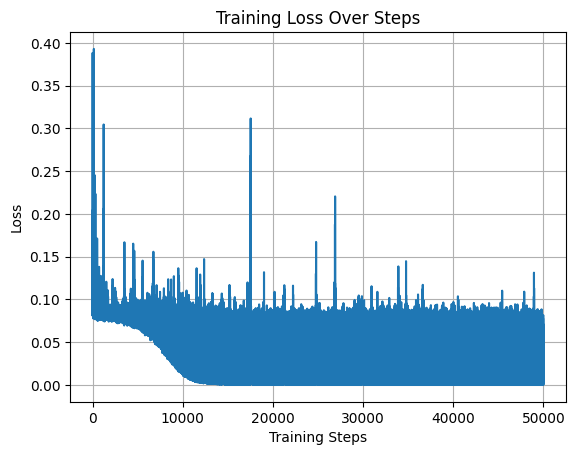

In [17]:
from tqdm.auto import tqdm

train_steps = 50000
T = 200
scale = 1000//T
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

betas = torch.linspace(1e-4*scale, 0.02*scale, T).to(device)
alphas = 1-betas
alpha_bars = torch.cumprod(alphas, dim=0).to(device)

x0 = sample_data()
x0 = x0.to(device)

loss_list = []
for _ in tqdm(range(train_steps)):

    noise = torch.rand_like(x0).to(device)

    t = torch.randint(low=1, high=T, size=(1,)).to(device)
    x_t1 = torch.sqrt(alpha_bars[t])*x0 + torch.sqrt(1-alpha_bars[t])*noise

    noise_pred = model(x_t1.to(device), t)

    loss = criterion(noise_pred, noise)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_list.append(loss.item())

plt.plot(loss_list)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training Loss Over Steps")
plt.grid(True)
plt.show()

## Reverse Diffusion Process DDPM

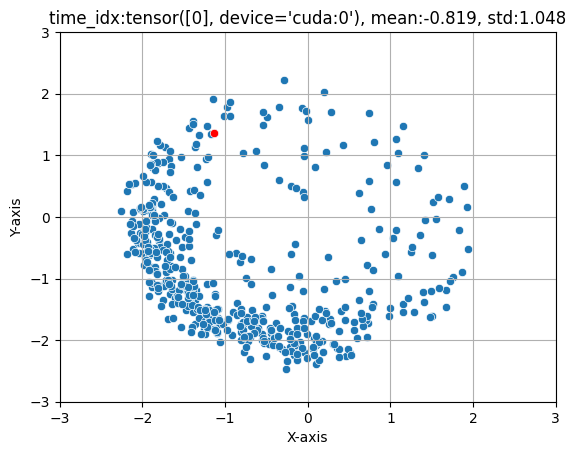

In [20]:
x_t = torch.randn_like(x0).to(device)

for t in reversed(range(T)[::1]):
    
    t = torch.tensor(t).unsqueeze(0).to(device)
    
    alpha_t = alphas[t].to(device)
    alpha_bar_t = alpha_bars[t].to(device)
    beta_t = betas[t].to(device)
    
    with torch.inference_mode():
        noise_pred = model(x_t,t)
    # Compute the mean mu_theta as per DDPM formula
    coef1 = 1 / torch.sqrt(alpha_t)
    coef2 = beta_t / torch.sqrt(1 - alpha_bar_t)
    mu_theta = coef1 * (x_t - coef2 * noise_pred)
    
    if t > 0:
        # Sample noise for the next step
        noise = torch.randn_like(x_t).to(device)
        sigma_t = torch.sqrt(beta_t).to(device)  # or learned covariance
        x_t = mu_theta + sigma_t * noise
    else:
        # At t=0, no noise added
        x_t = mu_theta
        
    if t%5==0 :
        sns.scatterplot(x=x_t[:, 0].cpu(), y=x_t[:, 1].cpu(), )
        sns.scatterplot(x=[x_t[10, 0].item()], y=[x_t[10, 1].item()], color='red')
        plt.xlabel('X-axis')
        plt.ylabel('Y-axis')
        plt.title(f'time_idx:{t}, mean:{torch.mean(x_t):.3f}, std:{torch.std(x_t):.3f}')
        plt.xlim(-3,3)
        plt.ylim(-3,3)
        # plt.legend()
        plt.grid(True)
        clear_output(wait=True)
        plt.show()